# Lecture 7. Transfer Learning

## Transfer learning
- 큰 데이터 셋에서 학습된 pretrained network의 weight를 사용하여 다른 예측문제에 활용 
    - 예) 동물과 일상과 관련된 사물을 분류하는 ImageNet data를 학습시킨 VGG16 네트워크의 일부를 사용하여 가구 종류를 분류하는 네트워크 학습에 활용 
- Convolution base만 활용
    - Convolution base는 사진에 나타나는 일반적인 개체의  특성을 파악하기 위한 feature extraction의 결과물 
    - Classifier 부분은 분류 목적에 맞게 특성화 된 부분
    - Fully connected layer 부분은 개체의 location에 대한 정보를 잃어버린 상태(flattened)
- 기존 모형이 학습한 데이터와 많이 다른 데이터에 적용하기 위해서는 앞의 몇 개 layer만 사용하는 것이 더 나음 
    - 앞 쪽의 layer은 지엽적이고 일반적인 feature map(e.g. visual edges, colors, and textures)
    - 더 깊은 부분의 layer는 보다 추상화된 feature map(e.g. "cat ear", "dog eye")
- 두 가지 방법 (1) Feature extraction, (2) Fine tuning 을 소개

## 7.1 Feature extraction
- 기존의 학습된 network에서 fully connected layer를 제외한 나머지 weight를 고정하고 새로운 목적에 맞는 fully connected layer를 추가하여 추가된 weight만 학습하는 방법
- `keras.applications` module이 지원하는  image classification models
    - Xception
    - VGG16
    - VGG19
    - ResNet50
    - InceptionV3
    - InceptionResNetV2
    - MobileNet
    - DenseNet
    - NASNet
    - MobileNetV2
    
    https://keras.io/applications/
<img src="figures/transfer.PNG" width="50%">


In [6]:
!pip install h5py 
#!pip install pillow 

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### Instantiating the VGG16 convolutional base

In [7]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 5s 0us/step


- Imagenet의 1000개의 카테고리를 분류하는 문제에 학습된 VGG16의 network와 weight를 불러옴 
    - `weights`: 모형의 weight의 초기값 
    - `include_top`: densely connected classifier를 포함할지 여부 
    - `input_shape`: 사용자가 입력할 이미지의 크기 shape


In [8]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### Feature extraction의 두 가지 방법
1. 위의 `conv_base`에 새로운 데이터를 입력하여 출력값을 numpy 배열로 저장하고 이를 새로운 모델의 입력값으로 사용. Convolution operation을 하지 않아도 되기 때문에 빠르게 학습. 하지만 data augmentation 방법을 사용할 수 없음.
2. `conv_base` 이후에 새로운 layer를 쌓아 확장한 뒤 전체 모델을 다시 학습. 모든 데이터가 convolution layer들을 통과해야 하기 때문에 학습이 느림. data augmentation 방법을 사용할 수 있음.

### 7.1.1 Feature extraction without data augmentation


- `conv_base`의 predict 메소드로 입력 이미지의 feature를 추출 

In [3]:
# train, validation, test 이미지가 들어있는 폴더 경로를 지정
train_dir = './data/cats_and_dogs_small/train'
validation_dir = './data/cats_and_dogs_small/validation'
test_dir = './data/cats_and_dogs_small/test'

In [9]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
train_features.shape, train_labels.shape

((2000, 4, 4, 512), (2000,))

- 출력된 feature가 4D array이기 때문에 새로운 DNN 모델에 입력으로 넣기 위해 2D array로 변환 

In [11]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [12]:
train_features.shape

(2000, 8192)

In [26]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 348us/step - loss: 0.5947 - acc: 0.6830 - val_loss: 0.4238 - val_acc: 0.8380
Epoch 2/30
2000/2000 [==============================] - 0s 186us/step - loss: 0.4094 - acc: 0.8120 - val_loss: 0.3524 - val_acc: 0.8720
Epoch 3/30
2000/2000 [==============================] - 0s 182us/step - loss: 0.3500 - acc: 0.8500 - val_loss: 0.3214 - val_acc: 0.8720
Epoch 4/30
2000/2000 [==============================] - 0s 179us/step - loss: 0.3048 - acc: 0.8745 - val_loss: 0.3004 - val_acc: 0.8860
Epoch 5/30
2000/2000 [==============================] - 0s 202us/step - loss: 0.2707 - acc: 0.8895 - val_loss: 0.2832 - val_acc: 0.8950
Epoch 6/30
2000/2000 [==============================] - 0s 195us/step - loss: 0.2542 - acc: 0.8985 - val_loss: 0.2751 - val_acc: 0.8960
Epoch 7/30
2000/2000 [==============================] - 0s 192us/step - loss: 0.2407 - acc: 0.9065 - val_loss: 0.2683 - val_acc: 0.8990


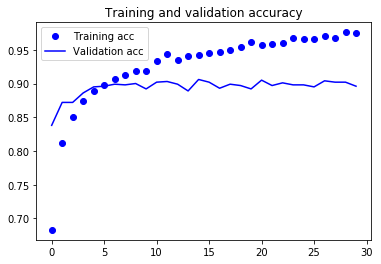

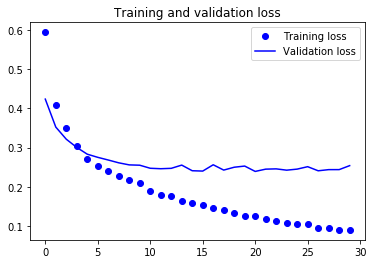

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 학습 속도가 매우 빠름
- 90% 정도의 validation accuracy에 도달함
- 이미지 증식을 하지 않았기 때문에 overfitting이 발생함 

### 7.1.2 Feature extraction with data augmentation

- VGG16의 network에 fully connected layer를 추가하여 모형 생성 

In [29]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import optimizers

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


- Network의 모든 weight가 학습되는 모형임
- VGG16에서 가져온 부분은 학습을 하지 않고 weight를 고정시킬 것이므로 아래와 같이  `trainable=False`를 설정

In [31]:
conv_base.trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


- `Non-trainable params`의 수가 `vgg16` layer의 parameter 수와 동일함을 확인

#### Defining image generators and fitting the model 

In [13]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [33]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

import time 
now = time.strftime("%c")
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='/tmp/logs/trasfer'+now)
model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=5, # 느린 학습속도 때문에 예시로 5 epoch만 학습
      validation_data=validation_generator,
      validation_steps=50,
      callbacks = [tensorboard])

Epoch 1/5
100/100 [==============================] - 38s 383ms/step - loss: 0.6821 - acc: 0.5970 - val_loss: 0.4855 - val_acc: 0.8140
Epoch 2/5
100/100 [==============================] - 35s 347ms/step - loss: 0.5791 - acc: 0.6835 - val_loss: 0.4132 - val_acc: 0.8240
Epoch 3/5
100/100 [==============================] - 35s 348ms/step - loss: 0.5137 - acc: 0.7490 - val_loss: 0.3737 - val_acc: 0.8620
Epoch 4/5
100/100 [==============================] - 34s 344ms/step - loss: 0.4661 - acc: 0.7770 - val_loss: 0.3401 - val_acc: 0.8640
Epoch 5/5
100/100 [==============================] - 35s 351ms/step - loss: 0.4529 - acc: 0.7890 - val_loss: 0.3304 - val_acc: 0.8700


- `conv_base`에 해당하는 weight를 학습하지는 않지만 새로운 이미지 학습데이터가 VGG16의 모든 convolution layer를 통과해야 하기 때문에 학습속도가 이전에 비해 현저히 느림
- Data augmentation을 통해 overfitting 방지 효과가 있음


## 7.2 Fine-tuning
- 기존 network에서 가져온 base에 사용자의 목적에 맞는 dense layer를 추가하는 부분은 이전과 동일 
- Base model의 weight을 모두 고정하지 않고 일부 top layer를 학습과정에서 함께 업데이트
- 주어진 문제에 더 적합하도록 모형을 조정하는 과정 

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [34]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [35]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### Selecting layers to be trained

In [36]:
conv_base.layers

In [37]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

- `block5_conv1`, `block5_conv2`,  `block5_conv3`를 fine-tune 시도 
    - 앞의 layer들은 비교적 일반적이고 재사용 가능한 feature를 학습
    - 너무 많은 parameter를 학습시키면 overfitting의 위험이 있음 (특히 새로운 데이터의 수가 적을 때)
    

In [39]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [40]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history2 = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 39s 385ms/step - loss: 0.5206 - acc: 0.7575 - val_loss: 0.3043 - val_acc: 0.8830
Epoch 2/30
100/100 [==============================] - 35s 345ms/step - loss: 0.3706 - acc: 0.8350 - val_loss: 0.2397 - val_acc: 0.8930
Epoch 3/30
100/100 [==============================] - 35s 347ms/step - loss: 0.3087 - acc: 0.8615 - val_loss: 0.2060 - val_acc: 0.9100
Epoch 4/30
100/100 [==============================] - 34s 344ms/step - loss: 0.2901 - acc: 0.8825 - val_loss: 0.2076 - val_acc: 0.9230
Epoch 5/30
100/100 [==============================] - 35s 348ms/step - loss: 0.2713 - acc: 0.8860 - val_loss: 0.1883 - val_acc: 0.9200
Epoch 6/30
100/100 [==============================] - 35s 347ms/step - loss: 0.2338 - acc: 0.9045 - val_loss: 0.1851 - val_acc: 0.9200
Epoch 7/30
100/100 [==============================] - 35s 351ms/step - loss: 0.2369 - acc: 0.8990 - val_loss: 0.1751 - val_acc: 0.9220
Epoch 8/30
100/100 [==============================] - 3

In [42]:
#model.save('cats_and_dogs_small_3.h5')

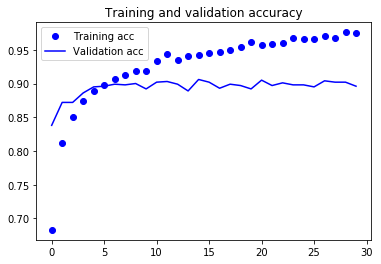

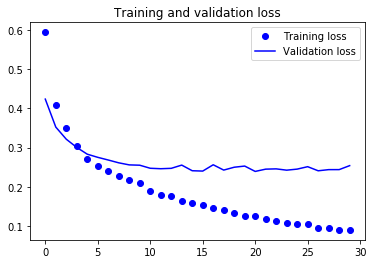

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_3.h5')
model.evaluate_generator(test_generator, steps=50)

[0.2362456788867712, 0.9329999911785126]


References
- https://www.coursera.org/specializations/deep-learning
- [Hands on Machine Learning with Scikit-Learn  and Tensorflow, Aurélien Géron]( http://www.hanbit.co.kr/store/books/look.php?p_code=B9267655530)
- [Deep Learning with Python, François Chollet,](https://www.manning.com/books/deep-learning-with-python)